In [286]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR

from sklearn.neural_network import BernoulliRBM , MLPRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor


from joblib import dump, load
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
import pandas as pd
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.style.use('seaborn')
%matplotlib inline
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', None)

In [287]:
df=pd.read_parquet('../data/processed/df.parquet')
dfd=pd.read_parquet('../data/processed/dfd.parquet')


In [288]:
dfd.columns

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'df_original', 'id',
       'cut_int', 'color_int', 'clarity_int', 'cut_color_clarity_score',
       'raw_density', 'marketing_carat_int', 'carat_sqr', 'high', 'cut_Fair',
       'cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D',
       'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J',
       'clarity_I1', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2', 'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular'],
      dtype='object')

In [289]:
#option 1

# dfd=dfd.drop(columns=['marketing_carat_int','cut_int','color_int', 'clarity_int'])

# #option 2
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score'])

# #option 3 espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','x', 'y', 'z'])

# #option 3 bis espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','raw_density'])

# #option 3 bis2 espero que sea la mejor
# dfd=dfd.drop(columns=[ 'marketing_carat_int','cut_int','color_int', 'clarity_int',
#                      'x', 'y', 'z'])

# #option 4
# dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','x', 'y', 'z','raw_density'])

# #option 5 SIN NADA
# dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
#                      'cut_color_clarity_score','raw_density','marketing_carat_bad',
#        'marketing_carat_good', 'marketing_carat_regular'])

#option 5 SIN NADA
dfd=dfd.drop(columns=['marketing_carat_int', 'cut_int','color_int', 'clarity_int',
                     'marketing_carat_bad',
       'marketing_carat_good', 'marketing_carat_regular','carat_sqr','cut_color_clarity_score','raw_density'])

In [290]:
#con carat y 5
# RandomForestRegressor       536.7894862874348
# ExtraTreesRegressor         524.3073747284154
# GradientBoostingRegressor   522.2696670624822
# CatBoostRegressor           515.8518906580055
# LGBMRegressor               520.4246279374379
# XGBRegressor                517.9044507009544
# StackingRegressor           504.8044508186878

#sin carat y 5
# RandomForestRegressor       536.5326496454497
# ExtraTreesRegressor         522.8754833840452
# GradientBoostingRegressor   521.8840694917378
# CatBoostRegressor           514.4646192634776
# LGBMRegressor               520.4418909188064
# XGBRegressor                517.6058680138955
# StackingRegressor           504.43703022069695


df=df.drop(columns=['cut','color', 'clarity','marketing_carat','marketing_carat_int','cut_color_clarity_score','carat_sqr',
                    'raw_density','high'])


#RandomForestRegressor        536.8794322366753
# ExtraTreesRegressor         522.5880641009147
# GradientBoostingRegressor   521.8113311805382
# CatBoostRegressor           515.7005012415111
# LGBMRegressor               520.4246279374379
# XGBRegressor
# StackingRegressor           505.6372856024203

# df=df.drop(columns=['cut','color', 'clarity','marketing_carat','marketing_carat_int','cut_color_clarity_score','carat_sqr'])



In [291]:
df.head()


,carat,depth,table,price,x,y,z,df_original,id,cut_int,color_int,clarity_int
0,1.21,62.4,58.0,4268.0,6.83,6.79,4.25,1,NaN,4,1,4
1,0.32,63.0,57.0,505.0,4.35,4.38,2.75,1,NaN,3,3,4
2,0.71,65.5,55.0,2686.0,5.62,5.53,3.65,1,NaN,1,4,5
3,0.41,63.8,56.0,738.0,4.68,4.72,3.00,1,NaN,2,7,3
4,1.02,60.5,59.0,4882.0,6.55,6.51,3.95,1,NaN,5,4,3


In [292]:
dfd.head()

,carat,depth,table,price,x,y,z,df_original,id,high,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,1.21,62.4,58.0,4268.0,6.83,6.79,4.25,1,NaN,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.32,63.0,57.0,505.0,4.35,4.38,2.75,1,NaN,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.71,65.5,55.0,2686.0,5.62,5.53,3.65,1,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
3,0.41,63.8,56.0,738.0,4.68,4.72,3.00,1,NaN,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1.02,60.5,59.0,4882.0,6.55,6.51,3.95,1,NaN,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0


## Split

In [293]:


df_final=df

data=df_final.loc[df['df_original']==1]

# data=data.loc[(data['carat']>=1.98)]

############## FILAS

# def remove_outlier(df, col):
#     q1 = df[col].quantile(0.25)
#     q3 = df[col].quantile(0.75)
#     iqr = q3-q1 
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_clean = df.loc[(df[col] > fence_low) & (df[col] < fence_high)]
#     return df_clean



# data=data.drop_duplicates(subset=data.columns, keep='first')

data['depth_calc'] = data['z'] / ((data['x'] + data['y'])/2)*100
data['rest']=data['depth_calc'] - data['depth'] 
filter_rest=(data['rest']<-1) | (data['rest']>1)
data=data.loc[~filter_rest]
data=data.drop(columns=['depth_calc','rest'],axis=1)

filter_xyz=(data['x']<0.2) | (data['y']<0.2) | (data['z']<0.2)
data=data.loc[~filter_xyz ]



df_predict=df_final.loc[df['df_original']==0]

X=data.drop(columns=['price','df_original','id'])
Y=data['price']

X_predict=df_predict.drop(columns=['price','df_original','id'])



# rs= StandardScaler()

# rs = RobustScaler() 

# X = pd.DataFrame(rs.fit_transform(X), columns= X.columns)
# X_predict = pd.DataFrame(rs.fit_transform(X_predict), columns= X_predict.columns)


df_predict.to_csv('../data/processed/df_predict.csv',index=False)
X.to_csv('../data/processed/X.csv',index=False)
Y.to_csv('../data/processed/Y.csv',index=False)
X_predict.to_csv('../data/processed/X_predict.csv',index=False)


print(5)
print(data.shape)
print(df_predict.shape)
print(X.shape)
print(X_predict.shape)
display(X)
display(X_predict)


/home/carpiero/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/carpiero/miniconda3/envs/ml_env/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5
(40380, 12)
(13485, 12)
(40380, 9)
(13485, 9)


,carat,depth,table,x,y,z,cut_int,color_int,clarity_int
0,1.21,62.4,58.0,6.83,6.79,4.25,4,1,4
1,0.32,63.0,57.0,4.35,4.38,2.75,3,3,4
2,0.71,65.5,55.0,5.62,5.53,3.65,1,4,5
3,0.41,63.8,56.0,4.68,4.72,3.00,2,7,3
4,1.02,60.5,59.0,6.55,6.51,3.95,5,4,3
5,1.52,61.2,57.0,7.45,7.39,4.54,5,5,2
6,1.01,65.2,56.0,6.23,6.19,4.05,1,3,4
7,1.52,62.3,58.0,7.32,7.35,4.57,5,1,5
8,0.31,61.8,54.2,4.33,4.37,2.69,5,3,5
...,...,...,...,...,...,...,...,...,...


,carat,depth,table,x,y,z,cut_int,color_int,clarity_int
0,0.79,62.7,60.0,5.82,5.89,3.67,3,5,3
1,1.20,61.0,57.0,6.81,6.89,4.18,5,1,5
2,1.57,62.2,61.0,7.38,7.32,4.57,4,3,3
3,0.90,63.8,54.0,6.09,6.13,3.90,3,5,3
4,0.50,62.9,58.0,5.05,5.09,3.19,3,5,5
5,1.01,61.3,61.0,6.38,6.34,3.90,4,5,4
6,1.04,61.0,58.0,6.60,6.54,4.01,4,3,3
7,0.91,63.1,61.0,6.10,6.16,3.87,2,7,3
8,1.13,62.2,55.0,6.69,6.67,4.15,5,2,4
...,...,...,...,...,...,...,...,...,...


## Model Generator

In [294]:
# arboles  de decision max_depth probar min sample split
# RandomForestRegressor(max_depth=40, min_samples_split=4, n_estimators=500, random_state=32)
# ('RandomForestRegressor', RandomForestRegressor(max_depth=32, min_samples_split=4, n_estimators=250, random_state=32)),
# max_depth=-1


estimators=[('XGBRegressor' , XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1)),
           ('ExtraTreesRegressor',ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,n_jobs = -1)),
           ('GradientBoostingRegressor',GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104)),
            ('CatBoostRegressor',CatBoostRegressor(depth = 8, iterations = 1200,silent=True)),
            ('LGBM' , LGBMRegressor( learning_rate =  0.05,n_estimators =  205, max_depth=11,n_jobs = -1,num_leaves=60)),
            
        ]

# estimators=[('MLPRegressor',DecisionTreeRegressor(max_depth=12, min_samples_leaf=7, min_samples_split=21) ),
#     ('XGBRegressor' , XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1)),
#            ('ExtraTreesRegressor',ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,n_jobs = -1)),
#            ('GradientBoostingRegressor',GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104)),
#             ('CatBoostRegressor',CatBoostRegressor(depth = 8, iterations = 1200,silent=True)),
#             ('LGBM' , LGBMRegressor( learning_rate =  0.05,n_estimators =  205, max_depth=11,n_jobs = -1,num_leaves=60)),
            
#         ]




machine = [ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,n_jobs = -1),
           GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,n_estimators=104),
           CatBoostRegressor(depth = 8, iterations = 1200,silent=True),
           LGBMRegressor( learning_rate =  0.05,n_estimators =  205, max_depth=11,n_jobs = -1,num_leaves=60),
           XGBRegressor(base_score=0.6 ,booster = 'gbtree' ,learning_rate=0.06,max_depth= 6 ,n_estimators=386,n_jobs = -1),
          StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1),
                               cv= 5 , verbose = 10 , passthrough = True),
          ]  


# machine = [  StackingRegressor(estimators=estimators,final_estimator= LinearRegression(n_jobs = -1) ,cv= 5 , 
#                                verbose = 2 , passthrough = True)]  

# LinearRegression(n_jobs = -1)
# ARDRegression(n_iter=1000)
# LogisticRegression(solver='lbfgs')

# machine = [CatBoostRegressor(depth = 8, iterations = 1200,silent=True)]

# machine = [  MLPRegressor() ]  


#LGBM CATEGORICAL FEATURES


for x in machine:
    print(f'Model in action: {x}\n')
    
#     X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.85, random_state=32)
    
######################           ENTRENAR AL FINAL CON TODO


        
        
#     model = x  
#     model.fit(X_train, Y_train)
    
    
#     predictions_train = model.predict(X_train)#.clip(326,18823)
#     predictions_test = model.predict(X_test)#.clip(326,18823)
 

    
#     print(f' R2 Train: {r2_score(y_true=Y_train, y_pred=predictions_train)}')
#     print(f' R2 Test: {r2_score(y_true=Y_test, y_pred=predictions_test)}')
#     print(f' RMSE = {(mean_squared_error(Y_test, predictions_test,squared=False))}\n\n')
    
    
    model = x  

    
    
    model.fit(X,Y)
    
#     model.eval_metrics(X,Y)
#     model.get_feature_importance(X,Y)
#     model.get_object_importance(X,Y)

    scores = cross_val_score(model, X, Y, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
    print(f' RMSE_CROSS = {np.mean(-scores)}\n\n')



        # SinROBUSTyConRAWDENSITYyConCARATSQR2
# ExtraTreesRegressor         523.534
# GradientBoostingRegressor   517.786  
# CatBoostRegressor           516.027 
# LGBMRegressor               521.557  
# XGBRegressor                518.264 
# StackingRegressor           505.110 


        # SinROBUSTySinRAWDENSITYyConCARATSQR2
# ExtraTreesRegressor         524.460
# GradientBoostingRegressor   520.599 
# CatBoostRegressor           515.747 
# LGBMRegressor               524.278 
# XGBRegressor                520.474 
# StackingRegressor           506.791

        # SinROBUSTyConRAWDENSITYySinCARATSQR2
# ExtraTreesRegressor         522.318
# GradientBoostingRegressor   517.817
# CatBoostRegressor           515.862
# LGBMRegressor               521.558
# XGBRegressor                518.264
# StackingRegressor           505.278

        # SinROBUSTySinRAWDENSITYySinCARATSQR2
# ExtraTreesRegressor         522.802325537371
# GradientBoostingRegressor   517.8027329518925 
# CatBoostRegressor           514.4090618198663 
# LGBMRegressor               520.575990618077 
# XGBRegressor                519.0832494708653
# StackingRegressor           505.68060485979805


Model in action: ExtraTreesRegressor(max_depth=16, min_samples_split=7, n_estimators=509,
                    n_jobs=-1)

 RMSE_CROSS = 523.1013709860581


Model in action: GradientBoostingRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=17,
                          n_estimators=104)

 RMSE_CROSS = 517.6308669771777


Model in action: <catboost.core.CatBoostRegressor object at 0x7f4e711dfd10>

 RMSE_CROSS = 514.4090618198663


Model in action: LGBMRegressor(learning_rate=0.05, max_depth=11, n_estimators=205, num_leaves=60)

 RMSE_CROSS = 520.575990618077


Model in action: XGBRegressor(base_score=0.6, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.06, max_delta_step=None, max_depth=6,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=386, n_jobs=-1, 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   37.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elap

 RMSE_CROSS = 505.77250218399604




In [275]:
print('TERMINADO\n\n\n')



# model.feature_importances_


TERMINADO





array([18.73906965,  0.76530349,  0.52659953, 11.00402041, 28.82518858,
       10.25292419,  0.82486129, 11.10324473, 17.19569171,  0.76309641])

## RandomizedSearchCV

In [214]:
# CatBoostRegressor(depth = 8, iterations = 1200,silent=True)

model2= DecisionTreeRegrssor()


#  'n_estimators': [16, 32, 64, 128, 256, 500],
#     'min_samples_split': [2, 8, 10, 12],
#     'max_depth' : [2, 4, 8, 10, 16, 32, 50, 75]
# min_samples_split
# min_samples_leaf=1
#leaves

# iterations=None,
#                         learning_rate=None,
#                         depth=None

# 'max_depth' :[4,6,8], 
#     'min_samples_split' :[14,16,18], 
#     'n_estimators':[120,200,300],
#     'min_samples_leaf' : [4,6,8],
# max_iter=200
# max_fun=15000

param_grid = {
'max_depth' :[9,10,11,12,13,14,15], 
    'min_samples_split':[8,12,16,17,18,19,20,21,22,23,24,25],
'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11]

}

# Randomized

grid_search = GridSearchCV(model2, 
                                 param_grid, 
                                 cv=5, 
                                 verbose=10, 
                                 scoring='neg_root_mean_squared_error', 
                                 n_jobs=-1,
                                )
# n_iter=32
grid_search.fit(X, Y)

NameError: name 'DecisionTreeRegrssor' is not defined

In [208]:
grid_search.best_params_

{'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 21}

In [209]:
grid_search.best_estimator_
# DecisionTreeRegressor(max_depth=16, min_samples_leaf=4, min_samples_split=32)

DecisionTreeRegressor(max_depth=12, min_samples_leaf=7, min_samples_split=21)

In [210]:
grid_search.best_score_
# -619.7859215141156

-609.6326688946157

## PROBAR RESULTADO

In [295]:
predictions_test = model.predict(X)
dfX_test=pd.DataFrame(X)
dfY_test=pd.DataFrame(Y)
dfpredictions_test=pd.DataFrame(predictions_test)
dftest=pd.concat([dfX_test.reset_index(drop=True),dfY_test.reset_index(drop=True),dfpredictions_test.reset_index(drop=True)], axis=1) 
dftest.rename(columns={0: 'price_predict'},inplace=True)
dftest['Diff']=dftest['price']-dftest['price_predict']




,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
76,1.64,60.7,55.0,7.67,7.64,4.65,5,6,3,9801.0,12043.211823,-2242.211823
146,1.72,62.8,57.0,7.65,7.58,4.78,5,4,4,12830.0,14842.207221,-2012.207221
352,1.58,60.8,58.0,7.58,7.52,4.59,4,4,5,11380.0,13471.138013,-2091.138013
694,1.27,61.8,55.0,7.03,6.92,4.31,5,6,4,6543.0,8945.423641,-2402.423641
897,2.07,59.6,60.0,8.30,8.24,4.93,4,3,2,11094.0,13556.019935,-2462.019935
...,...,...,...,...,...,...,...,...,...,...,...,...
39280,2.02,61.5,58.0,8.14,8.10,4.99,4,3,2,17166.0,14784.174634,2381.825366
39351,1.34,62.5,56.0,7.09,7.05,4.42,5,5,4,7504.0,9884.655515,-2380.655515
39366,2.09,62.5,57.0,8.21,8.14,5.11,5,4,2,11119.0,14138.021863,-3019.021863
39450,1.51,61.2,56.0,7.40,7.36,4.52,5,7,2,6934.0,9081.669580,-2147.669580


In [296]:
# dump(model, '/home/carpiero/ir/Kaggle/.joblib') 

predictions_competition = model.predict(X_predict)
submission = pd.DataFrame({'id': df_predict['id'], 'price': predictions_competition})
submission['id'] = submission['id'].astype('int64')

# submission.loc[94,'price'] =20631
# submission.loc[94,'price'] =20631


# submission.to_csv(f'/home/carpiero/IRONHACK/kaggle/sin_nada_{np.mean(-scores)}.csv', index=False)

PROBA=pd.concat([X_predict,submission], axis=1)

# c1=2.49
# c2=3.2
# p1=0.05
# p2=0.15

# PROBA['price'] = np.where((PROBA['carat']>=c1)&(PROBA['carat']<c2),PROBA['price']+PROBA['price']*p1,PROBA['price'])
# PROBA['price'] = np.where(PROBA['carat']>=c2,PROBA['price']+PROBA['price']*p2,PROBA['price'])

# submission=PROBA[['id','price']]

# submission.to_csv(f'/home/carpiero/IRONHACK/kaggle/SINNADAyaumentandoamano_{c1}_{p1}y_{c2}_{p2}.csv', index=False)

# submission.describe()



In [297]:

# SinROBUSTyConRAWDENSITYyConCARATSQR2
# count    13485.000000
# mean      3947.999179
# std       3958.699006
# min        163.363126
# 25%        934.982225
# 50%       2464.969051
# 75%       5278.298692
# max      18560.749100
# Name: price, dtype: float64  505.110 

# SinROBUSTySinRAWDENSITYyConCARATSQR2
# count    13485.000000
# mean      3948.926775
# std       3958.269583
# min        330.948345
# 25%        938.487300
# 50%       2455.687555
# 75%       5285.923421
# max      18534.746496
# Name: price, dtype: float64 506.791

# SinROBUSTyConRAWDENSITYySinCARATSQR2

# count    13485.000000
# mean      3947.837618
# std       3957.962843
# min        338.634208
# 25%        935.633835
# 50%       2452.391613
# 75%       5289.271769
# max      18374.874823
# Name: price, dtype: float64  505.278

#getdumies
# count    13485.000000
# mean      3948.839011
# std       3958.164000
# min        318.942978
# 25%        944.366057
# 50%       2444.931991
# 75%       5297.687753
# max      18902.506381
# Name: price, dtype: float64

#SinROBUSTySinRAWDENSITYySinCARATSQR2
# count    13485.000000
# mean      3947.396160
# std       3956.301710
# min        323.516320
# 25%        936.455943
# 50%       2446.378377
# 75%       5292.367311
# max      18360.274125
# Name: price, dtype: float64   506.345

#con high

# count    13485.000000
# mean      3947.695348
# std       3955.700575
# min        331.610443
# 25%        940.324036
# 50%       2453.506270
# 75%       5295.485017
# max      18500.671094
# Name: price, dtype: float64

#SinROBUSTySinRAWDENSITYySinCARATSQR2
# count    13485.000000
# mean      3947.410776
# std       3956.282793
# min        327.610218
# 25%        936.267406
# 50%       2449.525412
# 75%       5288.594664
# max      18308.752108
# Name: price, dtype: float64


PROBA['price'].describe()

count    13485.000000
mean      3947.323627
std       3956.067674
min        327.681515
25%        936.015442
50%       2450.825460
75%       5287.703114
max      18341.052796
Name: price, dtype: float64

In [478]:
PROBA.loc[(PROBA['price']>18000) | (PROBA['price']<0)  | (PROBA['carat']>2.9)  ].sort_values(by='price',  ascending=False)

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
7336,0.51,61.8,54.7,5.12,5.15,31.80,3,6,5,7336,100779.294364
1665,0.51,61.8,55.0,5.15,31.80,5.12,5,6,5,1665,69805.383704
9724,2.29,61.4,60.0,8.45,8.49,5.20,4,1,8,9724,18994.788115
2901,1.20,62.1,59.0,0.00,0.00,0.00,4,7,7,2901,18969.933877
94,5.01,65.5,59.0,10.74,10.54,6.98,1,1,1,94,18812.989506
1025,2.14,60.3,60.0,8.31,8.43,5.05,3,7,2,1025,18559.875603
3022,2.01,62.7,57.0,8.03,8.11,5.06,3,6,3,3022,18315.487600
4572,2.01,58.7,59.0,8.23,8.27,4.84,2,6,3,4572,18271.881970
9091,2.29,60.8,60.0,8.47,8.50,5.16,4,2,4,9091,18182.081084
6925,2.29,61.6,60.0,8.45,8.43,5.20,4,3,4,6925,18160.507043


In [479]:
PROBA.loc[(PROBA['cut_int']==1) & (PROBA['clarity_int']==1)  & (PROBA['color_int']==1)  ]

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
94,5.01,65.5,59.0,10.74,10.54,6.98,1,1,1,94,18812.989506
6418,2.72,68.2,56.0,8.46,8.43,5.76,1,1,1,6418,9301.757581
6608,0.70,64.7,59.0,5.59,5.50,3.59,1,1,1,6608,5378.319719
6668,0.96,59.5,60.0,6.28,6.23,3.72,1,1,1,6668,5641.660171


In [374]:
PROBA.loc[(PROBA['price']>18000) | (PROBA['price']<0)].describe()

,carat,depth,table,cut_int,color_int,clarity_int,id,price
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,2.102727,61.072727,58.909091,3.727273,4.181818,4.272727,7188.545455,18181.713093
std,0.223968,0.852163,2.385563,0.786245,1.887760,2.053821,4615.671725,128.955322
min,1.700000,59.600000,53.000000,3.000000,1.000000,2.000000,407.000000,18013.806236
25%,2.025000,60.650000,59.000000,3.000000,3.500000,2.500000,2764.500000,18097.213085
50%,2.140000,61.300000,60.000000,4.000000,4.000000,4.000000,9468.000000,18142.128533
75%,2.275000,61.600000,60.000000,4.000000,5.000000,5.500000,10554.500000,18230.278320
max,2.420000,62.400000,61.000000,5.000000,7.000000,8.000000,12782.000000,18429.692685


In [480]:
ct=1.98


In [481]:
# count       90.000000
# mean     15627.380493
# std       2002.732916
# min       7995.524075
# 25%      14964.466748
# 50%      16112.883947
# 75%      16657.651248
# max      18359.051088
# Name: price, dtype: float64

#con high
# count       90.000000
# mean     15585.970692
# std       1945.263487
# min       8408.464553
# 25%      14908.559693
# 50%      16024.381252
# 75%      16592.274384
# max      18500.671094
# Name: price, dtype: float64

# 1.98
# count      512.000000
# mean     15022.298750
# std       2072.747771
# min       6166.998184
# 25%      13960.571738
# 50%      15516.758186
# 75%      16452.486691
# max      18429.692685
# Name: price, dtype: float64


PROBA['price'].loc[(PROBA['carat']>=ct)].describe()

count      512.000000
mean     15035.043642
std       2116.864262
min       6493.533862
25%      13911.252712
50%      15466.519208
75%      16513.211716
max      18994.788115
Name: price, dtype: float64

In [31]:
# count    13395.000000
# mean      3868.933770
# std       3848.184557
# min        323.689995
# 25%        933.160547
# 50%       2419.907418
# 75%       5226.899091
# max      18283.119989
# Name: price, dtype: float64

#con high

# count    13395.000000
# mean      3869.498649
# std       3848.546187
# min        331.610443
# 25%        936.507781
# 50%       2421.647628
# 75%       5238.367114
# max      18349.737579
# Name: price, dtype: float64



PROBA['price'].loc[(PROBA['carat']<ct)].describe()

NameError: name 'ct' is not defined

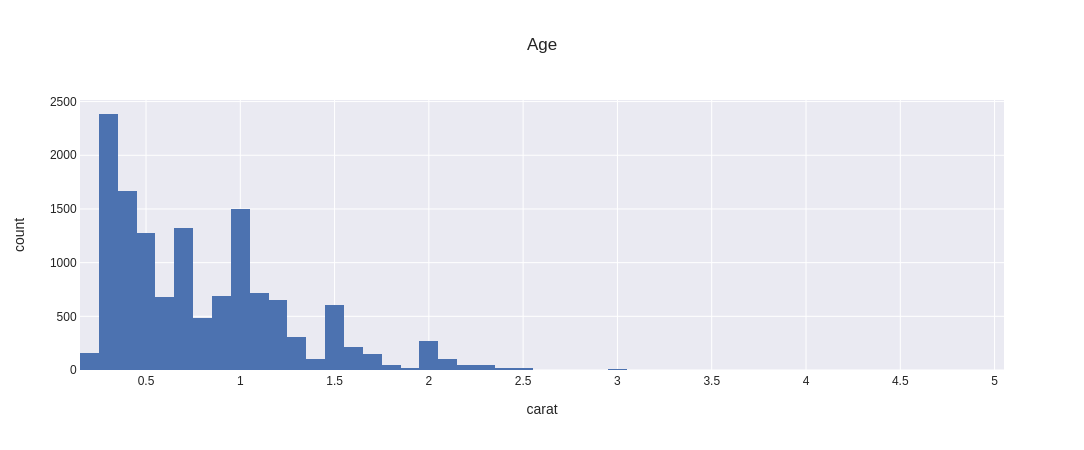

In [320]:
fig=px.histogram(PROBA, x='carat',nbins=50,template='seaborn',title='Age',barmode='group')
fig.show()

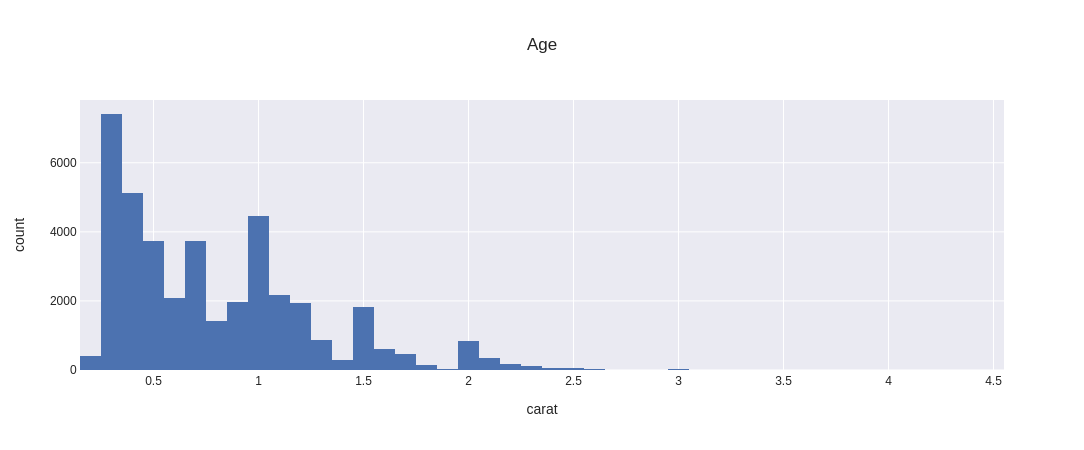

In [319]:
fig=px.histogram(X, x='carat',nbins=50,template='seaborn',title='Age',barmode='group')
fig.show()

In [52]:
data.loc[(data['carat']>=c1)&(data['carat']<c2)].describe()

,carat,depth,table,price,x,y,z,df_original,id,cut_int,color_int,clarity_int
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.0,0.0,103.000000,103.000000,103.000000
mean,2.653398,62.307767,58.233010,15104.650485,8.825340,8.766796,5.477767,1.0,NaN,3.310680,2.572816,2.019417
std,0.193307,2.239384,2.318738,3240.478117,0.272414,0.264920,0.155399,0.0,NaN,1.400484,1.459263,0.791878
min,2.490000,56.100000,53.000000,6289.000000,8.260000,8.180000,5.150000,1.0,NaN,1.000000,1.000000,1.000000
25%,2.510000,61.000000,57.000000,13989.000000,8.655000,8.600000,5.390000,1.0,NaN,2.000000,1.000000,2.000000
50%,2.560000,62.300000,58.000000,16239.000000,8.770000,8.730000,5.460000,1.0,NaN,4.000000,2.000000,2.000000
75%,2.720000,63.800000,60.000000,17565.000000,8.990000,8.935000,5.545000,1.0,NaN,4.000000,3.000000,2.000000
max,3.110000,67.000000,65.000000,18766.000000,9.540000,9.460000,5.980000,1.0,NaN,5.000000,7.000000,5.000000


In [53]:
PROBA.loc[(PROBA['carat']>=c1)&(PROBA['carat']<c2)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
count,28.000000,28.0000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2.680000,62.7750,58.392857,8.838214,8.774643,5.526786,3.107143,2.607143,1.857143,7660.535714,15626.696747
std,0.204885,2.3513,2.739820,0.255778,0.228627,0.177452,1.342725,1.571489,0.356348,3742.335976,2414.487980
min,2.500000,58.9000,53.000000,8.440000,8.420000,5.250000,1.000000,1.000000,1.000000,1388.000000,9670.969290
25%,2.527500,61.3000,56.000000,8.675000,8.632500,5.432500,2.000000,1.000000,2.000000,4196.500000,15555.857064
50%,2.565000,62.7000,58.500000,8.780000,8.720000,5.490000,3.000000,3.000000,2.000000,7317.000000,16455.567912
75%,2.805000,64.2250,59.250000,8.945000,8.910000,5.587500,4.000000,3.000000,2.000000,10942.000000,16894.033222
max,3.040000,68.2000,65.000000,9.420000,9.260000,5.970000,5.000000,7.000000,2.000000,13269.000000,18106.719510


In [54]:
data.loc[(data['carat']>=c2)].describe()

,carat,depth,table,price,x,y,z,df_original,id,cut_int,color_int,clarity_int
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,0.0,10.000000,10.000000,10.000000
mean,3.752000,63.420000,58.100000,15438.700000,9.806000,9.737000,6.197000,1.0,NaN,3.200000,2.500000,1.300000
std,0.433097,1.806039,2.998148,2375.842075,0.306384,0.300113,0.258502,0.0,NaN,1.619328,1.779513,0.948683
min,3.220000,61.000000,52.000000,12300.000000,9.420000,9.340000,5.850000,1.0,NaN,1.000000,1.000000,1.000000
25%,3.425000,62.500000,57.250000,13246.000000,9.530000,9.462500,6.030000,1.0,NaN,1.500000,1.250000,1.000000
50%,3.755000,62.700000,58.000000,15593.500000,9.830000,9.740000,6.205000,1.0,NaN,4.000000,2.000000,1.000000
75%,4.010000,64.425000,60.500000,16992.750000,10.017500,9.940000,6.300000,1.0,NaN,4.000000,3.000000,1.000000
max,4.500000,66.800000,62.000000,18701.000000,10.230000,10.160000,6.720000,1.0,NaN,5.000000,7.000000,4.000000


In [36]:
PROBA.loc[(PROBA['carat']>=c2)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
count,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.000000,3.0,3.0,3.000000,3.000000
mean,4.110000,65.000000,56.0,10.043333,9.943333,6.496667,2.000000,2.0,1.0,7412.333333,18158.966634
std,0.779487,2.389561,3.0,0.625486,0.542433,0.436845,1.732051,1.0,0.0,6456.781267,2045.322826
min,3.650000,62.400000,53.0,9.530000,9.480000,6.130000,1.000000,1.0,1.0,94.000000,16305.050237
25%,3.660000,63.950000,54.5,9.695000,9.645000,6.255000,1.000000,1.5,1.0,4966.000000,17061.927957
50%,3.670000,65.500000,56.0,9.860000,9.810000,6.380000,1.000000,2.0,1.0,9838.000000,17818.805677
75%,4.340000,66.300000,57.5,10.300000,10.175000,6.680000,2.500000,2.5,1.0,11071.500000,19085.924833
max,5.010000,67.100000,59.0,10.740000,10.540000,6.980000,4.000000,3.0,1.0,12305.000000,20353.043989


In [298]:
pd.set_option('display.max_rows', None)
dftest.loc[(dftest['Diff']>2000) | (dftest['Diff']<-2000)].sort_values(by='Diff', ascending=False)

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
29354,1.50,60.7,59.0,7.31,7.38,4.46,3,4,4,18691.0,13275.554288,5415.445712
2378,1.01,64.6,58.0,6.25,6.20,4.02,1,7,2,10011.0,5457.390212,4553.609788
20870,1.01,63.6,56.0,6.31,6.24,3.99,2,4,4,10181.0,6009.686298,4171.313702
31696,1.51,61.3,58.0,7.39,7.33,4.51,4,4,4,16091.0,12761.154403,3329.845597
21689,1.51,61.6,60.0,7.34,7.27,4.50,4,3,2,10485.0,7770.412800,2714.587200
3555,1.11,60.7,59.0,6.60,6.65,4.02,3,4,3,8184.0,5480.077431,2703.922569
27286,1.50,62.4,57.0,7.20,7.25,4.51,3,7,4,17153.0,14529.635320,2623.364680
3496,2.01,63.4,57.0,8.00,7.93,5.05,3,3,2,16111.0,13688.557500,2422.442500
39280,2.02,61.5,58.0,8.14,8.10,4.99,4,3,2,17166.0,14774.149683,2391.850317
34024,2.06,62.3,56.0,8.16,8.09,5.06,5,4,2,18293.0,15944.957940,2348.042060


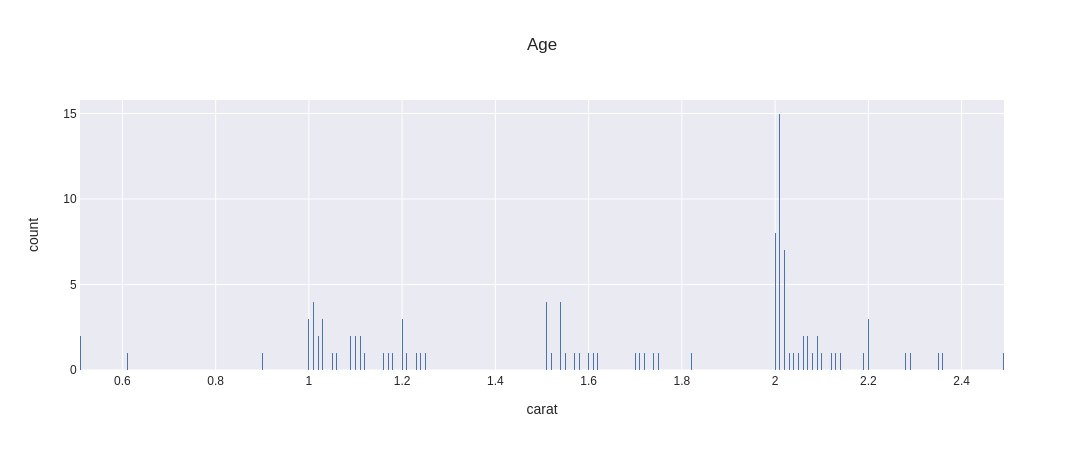

In [309]:
fig=px.histogram(dftest.loc[(dftest['Diff']>1500)], x='carat',nbins=1000,template='seaborn',title='Age',barmode='group')
fig.show()

In [300]:
dftest.loc[(dftest['Diff']>1000)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,1.600040,61.710060,57.501408,7.439014,7.420845,4.583843,4.080483,4.058350,3.486922,13503.549296,12129.511332,1374.037964
std,0.426992,1.268834,1.933391,0.713424,0.688620,0.430156,1.014791,1.475135,1.494725,4133.089508,4088.238721,419.464553
min,0.510000,56.800000,53.000000,4.980000,4.900000,3.130000,1.000000,1.000000,1.000000,3360.000000,1658.649172,1000.152132
25%,1.210000,61.100000,56.000000,6.840000,6.840000,4.210000,4.000000,3.000000,2.000000,10080.000000,8756.747615,1106.039521
50%,1.540000,61.700000,57.000000,7.450000,7.450000,4.590000,4.000000,4.000000,3.000000,13991.000000,12761.154403,1269.184026
75%,2.010000,62.400000,59.000000,8.110000,8.060000,4.990000,5.000000,5.000000,4.000000,17353.000000,15967.768190,1498.441796
max,2.610000,66.800000,66.000000,8.850000,8.750000,5.460000,5.000000,7.000000,8.000000,18818.000000,17726.468702,5415.445712


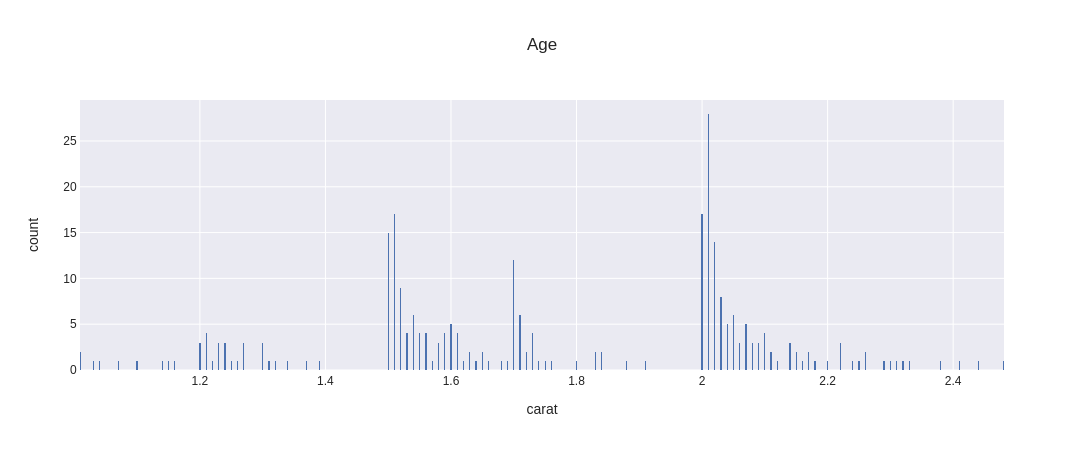

In [310]:
fig=px.histogram(dftest.loc[(dftest['Diff']<-1500)], x='carat',nbins=1000,template='seaborn',title='Age',barmode='group')
fig.show()

In [302]:
dftest.loc[(dftest['Diff']<-1000)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000,626.000000
mean,1.657077,61.771885,57.816294,7.549441,7.507029,4.650144,4.012780,3.790735,3.305112,9463.413738,11025.195653,-1561.781915
std,0.387130,1.282975,1.856394,0.608351,0.599697,0.375288,0.910295,1.526086,1.290410,3303.981206,3435.626762,509.976349
min,0.900000,58.100000,52.000000,6.140000,6.150000,3.830000,1.000000,1.000000,1.000000,2323.000000,3618.001552,-3627.227736
25%,1.360000,61.000000,57.000000,7.142500,7.082500,4.382500,4.000000,3.000000,2.000000,6700.000000,8273.576289,-1824.099343
50%,1.590000,61.900000,58.000000,7.535000,7.490000,4.620000,4.000000,4.000000,3.000000,9658.500000,11300.541571,-1426.351683
75%,2.010000,62.600000,59.000000,8.100000,8.050000,4.997500,5.000000,5.000000,4.000000,12373.750000,13930.778683,-1167.154465
max,3.010000,66.800000,64.000000,9.230000,9.100000,5.770000,5.000000,7.000000,8.000000,16131.000000,17207.516692,-1000.104762


In [303]:
dftest.describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000,40380.000000
mean,0.797073,61.754666,57.443618,5.728757,5.731073,3.538079,3.905498,4.401461,4.050669,3923.897276,3921.468890,2.428386
std,0.475117,1.420064,2.230542,1.122323,1.114165,0.692897,1.117254,1.701701,1.648097,3988.235221,3961.204217,358.593510
min,0.200000,52.300000,43.000000,3.770000,3.720000,2.260000,1.000000,1.000000,1.000000,326.000000,306.626987,-3627.227736
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,3.000000,3.000000,3.000000,945.000000,927.827255,-86.860629
50%,0.700000,61.800000,57.000000,5.690000,5.700000,3.520000,4.000000,4.000000,4.000000,2394.000000,2415.991424,-4.799458
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.030000,5.000000,6.000000,5.000000,5324.000000,5293.863385,103.695686
max,4.500000,79.000000,95.000000,10.230000,10.160000,6.720000,5.000000,7.000000,8.000000,18823.000000,18782.473853,5415.445712


In [315]:
dftest.loc[(dftest['carat']>=2)&(dftest['carat']<=2.02)&(dftest['Diff']<-1500)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.009492,61.901695,58.491525,8.088136,8.032203,4.987966,3.864407,3.101695,2.813559,11973.610169,14069.016669,-2095.406500
std,0.007293,1.431841,1.888010,0.098986,0.101116,0.067869,1.007859,1.347986,0.880333,1583.144253,1609.305360,519.301584
min,2.000000,58.600000,55.000000,7.820000,7.730000,4.780000,1.000000,1.000000,2.000000,8640.000000,10720.716186,-3546.127572
25%,2.000000,60.900000,57.000000,8.035000,7.975000,4.945000,4.000000,2.000000,2.000000,10829.500000,12914.465424,-2440.658518
50%,2.010000,62.100000,58.000000,8.090000,8.030000,5.000000,4.000000,3.000000,3.000000,11988.000000,13996.550703,-1959.248525
75%,2.010000,62.850000,60.000000,8.150000,8.100000,5.035000,4.500000,4.000000,3.000000,12995.000000,15386.952706,-1734.743370
max,2.020000,65.500000,64.000000,8.290000,8.250000,5.150000,5.000000,6.000000,5.000000,15105.000000,16907.256073,-1501.329735


In [318]:
dftest.loc[(dftest['carat']>=2)&(dftest['carat']<=2.02)&(dftest['Diff']>2000)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.000000
mean,2.014444,61.377778,58.666667,8.113333,8.052222,4.961111,4.0,4.111111,2.111111,17648.777778,15462.024043,2186.753735
std,0.005270,1.028078,1.936492,0.067082,0.074629,0.062339,0.5,1.269296,0.333333,797.071323,890.085652,149.678868
min,2.010000,59.900000,56.000000,8.000000,7.930000,4.850000,3.0,2.000000,2.000000,16111.000000,13688.557500,2015.551012
25%,2.010000,61.000000,57.000000,8.070000,7.990000,4.910000,4.0,3.000000,2.000000,17166.000000,14998.448988,2084.361374
50%,2.010000,61.300000,59.000000,8.140000,8.100000,4.980000,4.0,4.000000,2.000000,17746.000000,15482.120410,2149.231810
75%,2.020000,61.700000,59.000000,8.150000,8.110000,4.990000,4.0,5.000000,2.000000,18259.000000,16049.037464,2263.879590
max,2.020000,63.400000,62.000000,8.180000,8.120000,5.050000,5.0,6.000000,3.000000,18678.000000,16652.427851,2422.442500


In [317]:
dftest.loc[(dftest['carat']>=2)&(dftest['carat']<=2.02)].describe()

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,2.008919,61.935616,58.546880,8.059072,8.037747,4.982694,3.347032,3.006088,2.789954,14519.922374,14513.715090,6.207284
std,0.006977,2.036274,2.808647,0.133521,0.137075,0.096038,1.193783,1.548000,0.983874,2815.705386,2428.444297,994.859549
min,2.000000,55.300000,50.000000,7.530000,7.500000,4.640000,1.000000,1.000000,1.000000,5051.000000,5520.615730,-3546.127572
25%,2.000000,60.700000,57.000000,7.980000,7.960000,4.930000,3.000000,2.000000,2.000000,12565.000000,13089.461181,-503.124472
50%,2.010000,62.000000,59.000000,8.060000,8.050000,4.990000,4.000000,3.000000,3.000000,15014.000000,15024.775149,112.192367
75%,2.010000,63.000000,60.000000,8.140000,8.130000,5.040000,4.000000,4.000000,3.000000,16861.000000,16378.347277,634.393455
max,2.020000,70.200000,95.000000,8.800000,8.390000,5.370000,5.000000,7.000000,7.000000,18818.000000,18415.903361,2422.442500


In [325]:
PROBA.loc[(PROBA['carat']>=2)&(PROBA['clarity_int']==1)].sort_values(by='carat', ascending=False)

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,id,price
94,5.01,65.5,59.0,10.74,10.54,6.98,1,1,1,94,17811.080986
12305,3.67,62.4,56.0,9.86,9.81,6.13,4,2,1,12305,14216.219723
9838,3.65,67.1,53.0,9.53,9.48,6.38,1,3,1,9838,15528.448902
6399,3.00,59.7,60.0,9.42,9.26,5.58,4,4,1,6399,9476.368455
1798,3.00,64.2,65.0,9.08,8.96,5.79,2,6,1,1798,10317.841084
13269,3.00,67.1,57.0,8.93,8.84,5.97,1,3,1,13269,10559.613584
6418,2.72,68.2,56.0,8.46,8.43,5.76,1,1,1,6418,9558.364959
13452,2.34,62.4,55.4,8.44,8.51,5.29,3,3,1,13452,9199.221508
9044,2.30,60.2,59.0,8.71,8.56,5.19,4,4,1,9044,7993.051864
4604,2.23,63.5,57.0,8.24,8.20,5.22,3,4,1,4604,6889.293657


In [326]:
dftest.loc[(dftest['carat']>=2)&(dftest['clarity_int']==1)].sort_values(by='carat', ascending=False)

,carat,depth,table,x,y,z,cut_int,color_int,clarity_int,price,price_predict,Diff
31022,4.50,65.8,58.0,10.23,10.16,6.72,1,1,1,18531.0,17891.906115,639.093885
27839,4.13,64.8,61.0,10.00,9.85,6.43,1,3,1,17329.0,17076.615677,252.384323
23560,4.01,62.5,62.0,10.02,9.94,6.24,4,1,1,15223.0,15507.126382,-284.126382
3465,4.01,61.0,61.0,10.14,10.10,6.17,4,2,1,15223.0,15227.588826,-4.588826
2882,4.00,63.3,58.0,10.01,9.94,6.31,3,2,1,15984.0,15858.635565,125.364435
35457,3.50,62.8,57.0,9.65,9.59,6.03,5,3,1,12587.0,12736.778232,-149.778232
20387,3.40,66.8,52.0,9.42,9.34,6.27,1,7,1,15964.0,15823.499098,140.500902
18620,3.24,62.1,58.0,9.44,9.40,5.85,4,3,1,12300.0,12138.695273,161.304727
25397,3.22,62.6,55.0,9.49,9.42,5.92,5,2,1,12545.0,12536.789033,8.210967
20320,3.11,65.9,57.0,9.15,9.02,5.98,1,1,1,9823.0,10689.020005,-866.020005
